In [42]:
import tensorflow as tf
from keras.models import Model, Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Dropout, Flatten, Convolution2D, MaxPooling2D,ZeroPadding2D
from keras.layers import Input, Lambda
from keras import backend as K
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from keras.utils import plot_model

In [43]:

# Define aspects of the model and create instances of both the 
# test and train batch generators and the complete model.

imsize = 28
batch_size = 32
embedding_dim = 2 
LR = 0.0001
EPOCHS = 5
alpha = 0.2 
input_x=20
input_y=125
total_classes=2


In [44]:
import pickle

def get_image_count(file_path):
    # Open the file in binary mode for reading
    with open(file_path, 'rb') as f:
        # Load the data from the file using pickle
        loaded_data = pickle.load(f)

    # Check if the loaded data is a numpy array
    if isinstance(loaded_data, np.ndarray):
        # If loaded data is a numpy array, return the number of images (third dimension)
        return loaded_data.shape[2]
    else:
        # If loaded data is not a numpy array, return 0 (indicating no images)
        return 0

In [45]:
import os
import random
from sklearn.model_selection import train_test_split
import time



data_folder_path="data"
# Specify the directory path
X_seiz_train=[]
X_seiz_test=[]

X_bckg_train=[]
X_bckg_test=[]

image_count=20000  # How much images to load for trainig or testing

In [46]:
def reset_image_arr(test=0):
    global data_folder_path  # Assuming data_folder_path is defined globally

    # Initialize lists to store image data
    X_bckg_train, X_bckg_test, X_seiz_train, X_seiz_test = [], [], [], []

    # print("   --reset image started at", time.time(), test, len(X_bckg_train), len(X_bckg_test), len(X_seiz_train), len(X_seiz_test))

    if test == 2:
        # Define paths for seizure and background images in the test set
        seiz_folder_path_test = os.path.join(data_folder_path, "test_data/seiz")
        bckg_folder_path_test = os.path.join(data_folder_path, "test_data/bckg")
        seiz_file_names_test = os.listdir(seiz_folder_path_test)
        bckg_file_names_test = os.listdir(bckg_folder_path_test)

        # Load seizure images for test set
        while len(X_seiz_test) < image_count:
            i = random.randint(0, len(seiz_file_names_test) - 1)
            file_p = os.path.join(seiz_folder_path_test, seiz_file_names_test[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]     # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_seiz_test.append(loaded_data[:, :, i])

        # Load background images for test set
        while len(X_bckg_test) < image_count:
            i = random.randint(0, len(bckg_file_names_test) - 1)
            file_p = os.path.join(bckg_folder_path_test, bckg_file_names_test[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]    # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_bckg_test.append(loaded_data[:, :, i])

    else:
        # Define paths for seizure and background images in the train and validation sets
        seiz_folder_path_train = os.path.join(data_folder_path, "train_data/seiz")
        bckg_folder_path_train = os.path.join(data_folder_path, "train_data/bckg")
        seiz_folder_path_val = os.path.join(data_folder_path, "val_data/seiz")
        bckg_folder_path_val = os.path.join(data_folder_path, "val_data/bckg")

        seiz_file_names_train = os.listdir(seiz_folder_path_train)
        bckg_file_names_train = os.listdir(bckg_folder_path_train)
        seiz_file_names_val = os.listdir(seiz_folder_path_val)
        bckg_file_names_val = os.listdir(bckg_folder_path_val)

        # Load seizure images for training set
        while len(X_seiz_train) < image_count * 0.8:
            i = random.randint(0, len(seiz_file_names_train) - 1)
            file_p = os.path.join(seiz_folder_path_train, seiz_file_names_train[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]      # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_seiz_train.append(loaded_data[:, :, i])

        # Load seizure images for validation set
        while len(X_seiz_test) < image_count * 0.2:
            i = random.randint(0, len(seiz_file_names_val) - 1)
            file_p = os.path.join(seiz_folder_path_val, seiz_file_names_val[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]       # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_seiz_test.append(loaded_data[:, :, i])

        # Load background images for training set
        while len(X_bckg_train) < image_count * 0.8:
            i = random.randint(0, len(bckg_file_names_train) - 1)
            file_p = os.path.join(bckg_folder_path_train, bckg_file_names_train[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]       # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_bckg_train.append(loaded_data[:, :, i])

        # Load background images for validation set
        while len(X_bckg_test) < image_count * 0.2:
            i = random.randint(0, len(bckg_file_names_val) - 1)
            file_p = os.path.join(bckg_folder_path_val, bckg_file_names_val[i])
            with open(file_p, 'rb') as f:
                loaded_data = pickle.load(f)

            # Randomly select a fraction of images from the loaded data
            n = loaded_data.shape[2]      # Number of images in current pkl file
            x = min(1000, max(1, n // 4))
            idx_arr = set()
            while len(idx_arr) < x:
                idx_arr.add(random.randint(0, n - 1))
            for i in idx_arr:
                X_bckg_test.append(loaded_data[:, :, i])

    # print("   --reset image successfully at", time.time(), test, len(X_bckg_train), len(X_bckg_test), len(X_seiz_train), len(X_seiz_test))
    return X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test

In [47]:
def get_image(label, test=0):
    """
    Choose an image from our training or test data with the given label.

    Args:
        label (int): Label indicating the type of image (0 for background, 1 for seizure).
        test (int): Indicator for whether to select from test data (default 0 for training data).

    Returns:
        img: Selected image.
    """


    # Check label to determine whether to select background or seizure image
    if label == 0:  # Background image
        if test != 0:  # If test set
            idx = np.random.randint(len(X_bckg_test))  # Choose random index from test data
            img = X_bckg_test[idx]  # Select image
        else:  # If training set
            idx = np.random.randint(len(X_bckg_train))  # Choose random index from training data
            img = X_bckg_train[idx]  # Select image
    else:  # Seizure image
        if test != 0:  # If test set
            idx = np.random.randint(len(X_seiz_test))  # Choose random index from test data
            img = X_seiz_test[idx]  # Select image
        else:  # If training set
            idx = np.random.randint(len(X_seiz_train))  # Choose random index from training data
            img = X_seiz_train[idx]  # Select image

    return img

    
def get_triplet(test=0):
    """
    Choose a triplet (anchor, positive, negative) of images such that anchor and positive have the same label
    and anchor and negative have different labels.

    Args:
        test (int): Indicator for whether to select from test data (default 0 for training data).

    Returns:
        a: Anchor image.
        p: Positive image.
        n: Negative image.
    """

    # Randomly choose a class for anchor image
    a_class = np.random.randint(total_classes)

    # Choose a different class for negative image
    n_class = 1 - a_class

    # Choose anchor and positive images from the same class
    anchor, positive = get_image(a_class, test), get_image(a_class, test)

    # Choose negative image from a different class
    negative = get_image(n_class, test)

    return anchor, positive, negative


def generate_triplets(test=0):
    """
    Generate an un-ending stream (i.e., a generator) of triplets for training or test.

    Args:
        test (int): Indicator for whether to generate triplets from test data (default 0 for training data).

    Yields:
        tuple: A tuple containing anchor, positive, negative images and a dummy label.
    """
    global X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test

    # Infinite loop to continuously generate triplets
    limit = 0  # Counter for resetting image arrays
    while True:
        if limit % 200 == 0:
            # print("--Calling reset_image at ", time.time())  # Print timestamp when resetting images
            X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test = reset_image_arr(test)  # Reset image arrays

        # Initialize lists to store anchor, positive, and negative images
        list_a = []
        list_p = []
        list_n = []

        # Generate triplets for each batch
        for _ in range(batch_size):
            a, p, n = get_triplet(test)  # Get a triplet of images
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)

        # Convert lists to numpy arrays
        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')

        # Dummy label which will be ignored in the loss function
        label = np.ones(batch_size)

        # Yield the triplet data and dummy label
        yield [A, P, N], label

        # Increment limit counter
        limit += 1

        


In [48]:
def generate_classification_data(test=0):
    """
    Generate an un-ending stream (i.e., a generator) of classification data for training or test.

    Args:
        test (int): Indicator for whether to generate data from test data (default 0 for training data).

    Yields:
        tuple: A tuple containing images and their corresponding labels.
    """
    global X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test

    # Infinite loop to continuously generate classification data
    limit = 0  # Counter for resetting image arrays
    while True:
        if limit % 200 == 0:
            # print("--Calling reset_image at ", time.time())  # Print timestamp when resetting images
            X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test = reset_image_arr(test)  # Reset image arrays

        a = []  # List to store images
        label = []  # List to store labels

        # Generate images and labels for each batch
        for _ in range(batch_size):
            img_class = np.random.randint(2)
            img = get_image(img_class, test)  # Get a image with label img_class
            a.append(img)
            label.append(img_class)  # Add label 0 for background image or 1 for seizure image
            # if img_class==0:
            #     label.append([1,0])
            # else:
            #     label.append([0,1])

        # Convert lists to numpy arrays
        A = np.array(a, dtype='float32')
        label = np.array(label)

        # Shuffle the arrays while maintaining the correspondence between image and label
        rng_state = np.random.get_state()
        np.random.shuffle(A)
        np.random.set_state(rng_state)
        np.random.shuffle(label)

        # Yield the image data and labels
        yield [A], label

        # Increment limit counter
        limit += 1


In [49]:
def mean_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.2):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss

def embedding_model():
    # Simple convolutional model 
    # used for the embedding model.
    model = Sequential()
    model.add(Input(shape=(input_x, input_y, 1), name='input_layer'))  # Input layer
    model.add(Convolution2D(32, (3, 3), activation='relu', name='convolution_1'))
    model.add(Convolution2D(64, (3, 3), activation='relu', name='convolution_2'))
    model.add(MaxPooling2D(pool_size=(2,2), name='max_pooling'))
    # model.add(Dropout(0.25, name='dropout_1'))
    model.add(Flatten(name='flatten'))
    model.add(Dense(256, activation='relu', name='dense_1'))
    # model.add(Dropout(0.5, name='dropout_2'))
    model.add(Dense(64, name='dense_2'))
    return model


def complete_model(base_model):
    # Create the complete model with three
    # embedding models and minimize the loss 
    # between their output embeddings
    input_1 = Input((input_x, input_y,1), name='input_layer_A')
    input_2 = Input((input_x, input_y,1), name='input_layer_P')
    input_3 = Input((input_x, input_y,1), name='input_layer_N')
        
    A = base_model(input_1)
    P = base_model(input_2)
    N = base_model(input_3)
   
    loss = Lambda(triplet_loss)([A, P, N]) 
    model = Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=mean_loss, optimizer=Adam(LR))
    return model
  

In [50]:
train_generator_emd = generate_triplets()
val_generator_emd = generate_triplets(test=1)

emd_model = embedding_model()
cmp_model = complete_model(emd_model)
cmp_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer_A (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 input_layer_P (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 input_layer_N (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 sequential_4 (Sequential)   (None, 64)                   7899840   ['input_layer_A[0][0]',       
                                                                     'input_layer_P[0][0]', 

In [51]:
# plot_model(cmp_model, to_file="model_5.png", show_shapes=True)

In [52]:
emd_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 18, 123, 32)       320       
                                                                 
 convolution_2 (Conv2D)      (None, 16, 121, 64)       18496     
                                                                 
 max_pooling (MaxPooling2D)  (None, 8, 60, 64)         0         
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               7864576   
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
Total params: 7899840 (30.14 MB)
Trainable params: 789

Training


In [54]:
# # Fit the model using triplet images provided by the train batch generator.
# # Save the trained weights.

# from keras.callbacks import ModelCheckpoint

# # Define a callback to save the model weights after each epoch
# checkpoint_callback = ModelCheckpoint(filepath='model_weights/siamese_model_6.h5', 
#                                       save_weights_only=False,
#                                       verbose=1)



# # Fit the model with the callback
# # with tf.device("/cpu:0"):
# history = cmp_model.fit_generator(train_generator_emd, 
#                             validation_data=val_generator_emd, 
#                             epochs=10, 
#                             verbose=1,
#                             steps_per_epoch=10000, 
#                             validation_steps=300,
#                             callbacks=[checkpoint_callback])





In [55]:
from keras.models import load_model

In [56]:
emd_model_arc = embedding_model()
complete_model = complete_model(emd_model_arc)
complete_model.load_weights('model_weights/siamese_model_6.h5')

In [57]:
complete_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer_A (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 input_layer_P (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 input_layer_N (InputLayer)  [(None, 20, 125, 1)]         0         []                            
                                                                                                  
 sequential_5 (Sequential)   (None, 64)                   7899840   ['input_layer_A[0][0]',       
                                                                     'input_layer_P[0][0]', 

In [58]:
emd_model = embedding_model()

emd_model = complete_model.get_layer('sequential_5')

# # # Get the weights of the sequential part
# # sequential_weights = sequential_model.get_weights()


In [59]:
emd_model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convolution_1 (Conv2D)      (None, 18, 123, 32)       320       
                                                                 
 convolution_2 (Conv2D)      (None, 16, 121, 64)       18496     
                                                                 
 max_pooling (MaxPooling2D)  (None, 8, 60, 64)         0         
                                                                 
 flatten (Flatten)           (None, 30720)             0         
                                                                 
 dense_1 (Dense)             (None, 256)               7864576   
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
Total params: 7899840 (30.14 MB)
Trainable params: 789

In [ ]:
X_seiz_train, X_seiz_test, X_bckg_train, X_bckg_test=reset_image_arr(test=2)

In [ ]:
bi=[]
si=[]
n_sample = 1000
for i in range(n_sample):
    bi.append(get_image(0,2).reshape(1, 20, 125, 1))
    si.append(get_image(1,2).reshape(1, 20, 125, 1))


In [ ]:
bi=np.array(bi)
si=np.array(si)
bi.shape

In [ ]:
se=[]
be=[]

for i in bi:
    be.append(emd_model.predict(i))

for i in si:
    se.append(emd_model.predict(i))

be=np.array(be)
se=np.array(se)


In [ ]:
se.shape, be.shape

TSNE in 2d

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Concatenate them along the first axis
all_data = np.concatenate((be.reshape(-1, 64), se.reshape(-1, 64)), axis=0)
labels = np.concatenate((np.zeros((be.shape[0],)), np.ones((se.shape[0],))))

# Calculate an appropriate perplexity value
perplexity_value = min(30, np.sqrt(1000))  # Adjust as needed

# Apply t-SNE to reduce dimensionality to 2D
tsne = TSNE(n_components=2, perplexity=perplexity_value, random_state=42)
embedded_data = tsne.fit_transform(all_data)

# Plotting
plt.figure(figsize=(8, 6))
plt.scatter(embedded_data[labels == 0, 0], embedded_data[labels == 0, 1], c='b', label='Class 1')
plt.scatter(embedded_data[labels == 1, 0], embedded_data[labels == 1, 1], c='r', label='Class 2')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.title('t-SNE Plot')
plt.legend()
plt.grid(True)
plt.show()


NameError: name 'be' is not defined

TSNE in 3d

In [ ]:
# Concatenate them along the first axis
all_data = np.concatenate((be.reshape(-1, 64), se.reshape(-1, 64)), axis=0)
labels = np.concatenate((np.zeros((be.shape[0],)), np.ones((se.shape[0],))))

# Apply t-SNE to reduce dimensionality to 2D
perplexity_value = 10  # Adjust this value as needed
perplexity_value = min(30, np.sqrt(n_sample))  # Adjust as needed
tsne = TSNE(n_components=3, perplexity=perplexity_value, random_state=42)
embedded_data = tsne.fit_transform(all_data)

# Plotting in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for each class
ax.scatter(embedded_data[labels == 0, 0], embedded_data[labels == 0, 1], embedded_data[labels == 0, 2], c='b', label='Class 1')
ax.scatter(embedded_data[labels == 1, 0], embedded_data[labels == 1, 1], embedded_data[labels == 1, 2], c='r', label='Class 2')

# Set labels and title
ax.set_xlabel('t-SNE Dimension 1')
ax.set_ylabel('t-SNE Dimension 2')
ax.set_zlabel('t-SNE Dimension 3')
ax.set_title('t-SNE Plot')

# Add legend
ax.legend()


plt.show()


In [ ]:
x=[]
y=[]
for i in range(100):
    for j in range(100):
        bb=K.sum(K.square(be[i]-be[j]),axis=1)
        bb=bb.numpy()[0]
        x.append(0)
        y.append(bb)

        ss=K.sum(K.square(se[i]-se[j]),axis=1)
        ss=ss.numpy()[0]
        x.append(2)
        y.append(ss)

        sb=K.sum(K.square(se[i]-be[j]),axis=1)
        sb=sb.numpy()[0]
        x.append(1)
        y.append(sb)

x=np.array(x)
y=np.array(y)

In [ ]:
x.shape, y.shape

In [ ]:
plt.scatter(x, y)

# Adding labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Scatter Plot Example')

# Displaying the plot
plt.show()

In [60]:

def classification_model(embedding_model):
    """
    Create a classification model on top of the embedding model.
    
    Args:
    embedding_model: Pretrained embedding model
    
    Returns:
    classification_model: Model for classification on top of the embedding model
    """
    # Freeze the layers of the embedding model
    for layer in embedding_model.layers:
        layer.trainable = False
    
    model = Sequential()
    model.add(Input(shape=(input_x, input_y, 1), name='input_layer'))  # Input layer
    model.add(embedding_model)
    # model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(16, activation='relu'))
    model.add(Dense(2, activation='softmax'))  # 2 classes for binary classification
    
    return model


In [61]:

# Create the classification model
classifier_model = classification_model(emd_model)

# Compile the model
classifier_model.compile(optimizer='adam',
                          loss='sparse_categorical_crossentropy',
                          metrics=['accuracy'])


In [62]:
classifier_model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 64)                7899840   
                                                                 
 dense_4 (Dense)             (None, 32)                2080      
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_5 (Dense)             (None, 16)                528       
                                                                 
 dense_6 (Dense)             (None, 2)                 34        
                                                                 
Total params: 7902482 (30.15 MB)
Trainable params: 2642 (10.32 KB)
Non-trainable params: 7899840 (30.14 MB)
_________________________________________________________________


In [63]:
train_generator_cls=generate_classification_data()
val_generator_cls=generate_classification_data(test=1)


In [ ]:
from keras.callbacks import ModelCheckpoint

# Define a callback to save the model weights after each epoch
checkpoint_callback = ModelCheckpoint(filepath='model_weights/siamese_classification_model_6.h5', 
                                      save_weights_only=False,
                                      verbose=1)

# Fit the model with the callback
history = classifier_model.fit_generator(train_generator_cls, 
                              validation_data=val_generator_cls, 
                              epochs=4, 
                              verbose=1,
                              steps_per_epoch=10000, 
                              validation_steps=300,
                              callbacks=[checkpoint_callback])

In [65]:
emd_model_arc = embedding_model()
classifier_model_final = classification_model(emd_model_arc)
classifier_model_final.load_weights('model_weights/siamese_classification_model_6.h5')

In [ ]:
rnd_image=get_image(0,2).reshape(1, 20, 125, 1)


In [ ]:
rnd_image=get_image(1,2).reshape(1, 20, 125, 1)
classifier_model_final.predict(rnd_image)

1/1 [==============================] - 0s 10ms/step


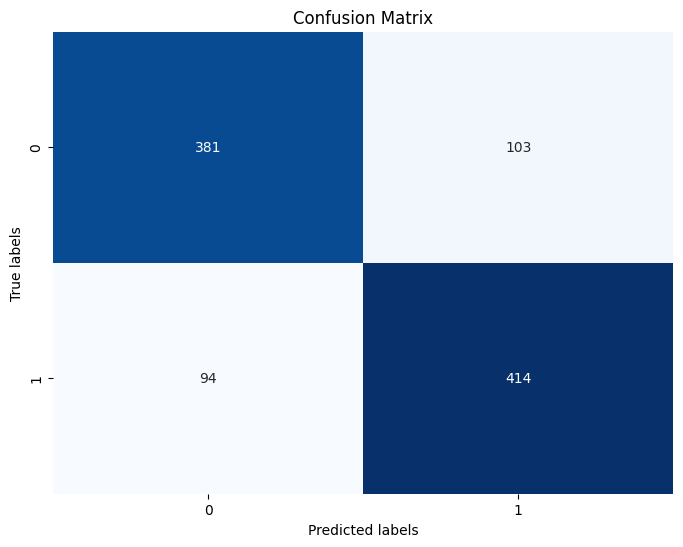

              precision    recall  f1-score   support

           0       0.80      0.79      0.79       484
           1       0.80      0.81      0.81       508

    accuracy                           0.80       992
   macro avg       0.80      0.80      0.80       992
weighted avg       0.80      0.80      0.80       992



In [66]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming you have already defined and loaded your model
# model = ...

# Generate data
num_samples=1000

data_generator = generate_classification_data(test=2)

# Initialize lists to store true labels and predicted labels
true_labels = []
predicted_labels = []

# Iterate over the generated data and obtain predictions
for i in range(num_samples // batch_size):  # Adjust num_samples as per your need
    X, y_true = next(data_generator)
    y_pred = classifier_model_final.predict(X)  # Assuming model.predict returns probabilities

    true_labels.extend(y_true)
    predicted_labels.extend(np.argmax(y_pred, axis=1))  # Convert probabilities to class labels

# Compute confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix")
plt.show()

# Compute and print classification report
print(classification_report(true_labels, predicted_labels))


In [74]:
import pandas as pd 

In [79]:

def test_complete_folder(pkl_folder_path, label,model):
    file_name_arr = os.listdir(pkl_folder_path)
    c_pkl = 0
    c_img = 0
    c_true_pkl = 0
    c_true_img = 0
    a=[]
    b=[]
    c=[]
    d=[]
    for i in range(len(file_name_arr)):
        file_name = file_name_arr[i]
        file_path = os.path.join(pkl_folder_path,file_name)
        with open(file_path, 'rb') as f:
            # Load the data from the file using pickle
            loaded_data = pickle.load(f)
        print("-->",len(file_name_arr),i,loaded_data.shape[2])
        loaded_data=np.transpose(loaded_data, (2, 0, 1))

        y_pred = model.predict(loaded_data)

        y_pred = np.argmax(y_pred, axis=1)

        c_pkl+=1 
        c_img+=len(y_pred)

        curr_true = 0
        for curr_label in y_pred:
            if curr_label==label:
                c_true_img+=1 
                curr_true+=1 

        a.append(len(y_pred))
        b.append(curr_true)
        
        print("-------->>>",curr_true)
        if curr_true>len(y_pred)//2:
            c_true_pkl+=1 
            c.append(1)
        else:
            c.append(0)
        d.append(file_name)
    df = pd.DataFrame({"file_name":d, "total_images":a, "true_predicted":b, "is_good_pkl":c})
    df.to_excel(f"model_results_{label}.xlsx", index=False)
    return [c_img, c_pkl, c_true_img, c_true_pkl]



In [80]:
num_img = 0
num_pkl = 0

correct_img = 0
correct_pkl = 0

bckg_path = "data/test_data/bckg"
seiz_path = "data/test_data/seiz"


In [81]:
bckg_results  = test_complete_folder(bckg_path,0,classifier_model_final)

print(bckg_results)

--> 1005 0 1206
38/38 [==============================] - 0s 7ms/step
-------->>> 1115
--> 1005 1 1
1/1 [==============================] - 0s 57ms/step
-------->>> 1
--> 1005 2 1
1/1 [==============================] - 0s 13ms/step
-------->>> 1
--> 1005 3 1
1/1 [==============================] - 0s 11ms/step
-------->>> 1
--> 1005 4 1206
38/38 [==============================] - 0s 5ms/step
-------->>> 1204
--> 1005 5 1210
38/38 [==============================] - 0s 5ms/step
-------->>> 1049
--> 1005 6 1
1/1 [==============================] - 0s 15ms/step
-------->>> 1
--> 1005 7 1
1/1 [==============================] - 0s 11ms/step
-------->>> 1
--> 1005 8 1
1/1 [==============================] - 0s 20ms/step
-------->>> 1
--> 1005 9 1
1/1 [==============================] - 0s 17ms/step
-------->>> 1
--> 1005 10 1
1/1 [==============================] - 0s 17ms/step
-------->>> 1
--> 1005 11 2420
76/76 [==============================] - 0s 4ms/step
-------->>> 2420
--> 1005 12 1
1/1 [===

In [82]:
seiz_results  = test_complete_folder(seiz_path,1,classifier_model_final)

print(seiz_results)

--> 836 0 12742
399/399 [==============================] - 2s 5ms/step
-------->>> 12173
--> 836 1 81
3/3 [==============================] - 0s 16ms/step
-------->>> 79
--> 836 2 371
12/12 [==============================] - 0s 5ms/step
-------->>> 370
--> 836 3 108
4/4 [==============================] - 0s 7ms/step
-------->>> 108
--> 836 4 227
8/8 [==============================] - 0s 11ms/step
-------->>> 56
--> 836 5 145
5/5 [==============================] - 0s 7ms/step
-------->>> 137
--> 836 6 399
13/13 [==============================] - 0s 6ms/step
-------->>> 176
--> 836 7 140
5/5 [==============================] - 0s 7ms/step
-------->>> 72
--> 836 8 28
1/1 [==============================] - 0s 27ms/step
-------->>> 27
--> 836 9 205
7/7 [==============================] - 0s 8ms/step
-------->>> 119
--> 836 10 151
5/5 [==============================] - 0s 10ms/step
-------->>> 151
--> 836 11 557
18/18 [==============================] - 0s 8ms/step
-------->>> 541
--> 836 12 109

In [83]:
print("Accuracy img",(seiz_results[2]+bckg_results[2])/(seiz_results[0]+bckg_results[0]))
print("Accuracy pkl",(seiz_results[3]+bckg_results[3])/(seiz_results[1]+bckg_results[1]))


Accuracy img 0.7897064935707929
Accuracy pkl 0.8718087995654535


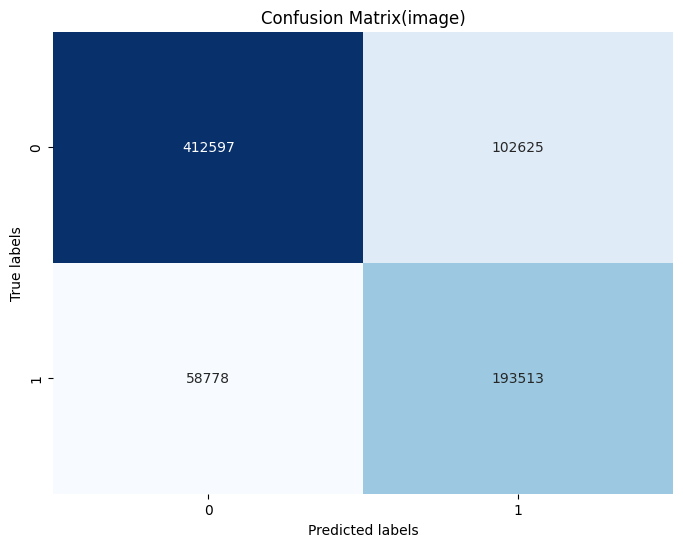

              precision    recall  f1-score   support

           0       0.88      0.80      0.84    515222
           1       0.65      0.77      0.71    252291

    accuracy                           0.79    767513
   macro avg       0.76      0.78      0.77    767513
weighted avg       0.80      0.79      0.79    767513



In [86]:
true_labels_img = [1] * seiz_results[0] + [0] * bckg_results[0]  # assuming n and m are the counts of class 1 and class 2 images respectively

# Predicted labels
predicted_labels_img = [1] * seiz_results[2] + [0] * (seiz_results[0]-seiz_results[2]) +[0] * bckg_results[2] + [1] * (bckg_results[0]-bckg_results[2]) # assuming a and b are the counts of correct predictions for class 1 and class 2 respectively

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels_img, predicted_labels_img)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix(image)")
plt.show()

# Compute and print classification report
print(classification_report(true_labels_img, predicted_labels_img))

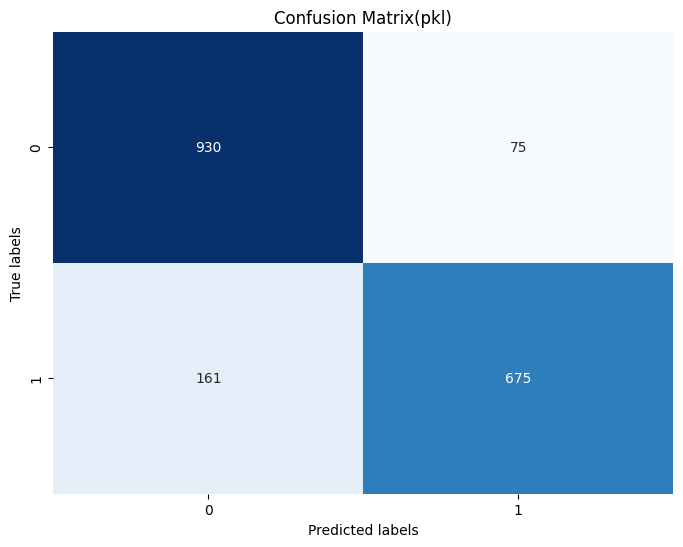

              precision    recall  f1-score   support

           0       0.85      0.93      0.89      1005
           1       0.90      0.81      0.85       836

    accuracy                           0.87      1841
   macro avg       0.88      0.87      0.87      1841
weighted avg       0.87      0.87      0.87      1841



In [87]:
true_labels_pkl = [1] * seiz_results[1] + [0] * bckg_results[1]  # assuming n and m are the counts of class 1 and class 2 images respectively

# Predicted labels
predicted_labels_pkl = [1] * seiz_results[3] + [0] * (seiz_results[1]-seiz_results[3]) +[0] * bckg_results[3] + [1] * (bckg_results[1]-bckg_results[3]) # assuming a and b are the counts of correct predictions for class 1 and class 2 respectively

# Create confusion matrix
conf_matrix = confusion_matrix(true_labels_pkl, predicted_labels_pkl)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
plt.title("Confusion Matrix(pkl)")
plt.show()

# Compute and print classification report
print(classification_report(true_labels_pkl, predicted_labels_pkl))